# Метрика качества

Предположим, что для нашего кейса еще не было изобретено никаких рекомендаций. Возможно существует POP бейзлайн. Мы же желаем заполнить рекомендациями какую-то область человеческого внимания. Пускай это будут k начальных элементов главной страницы:

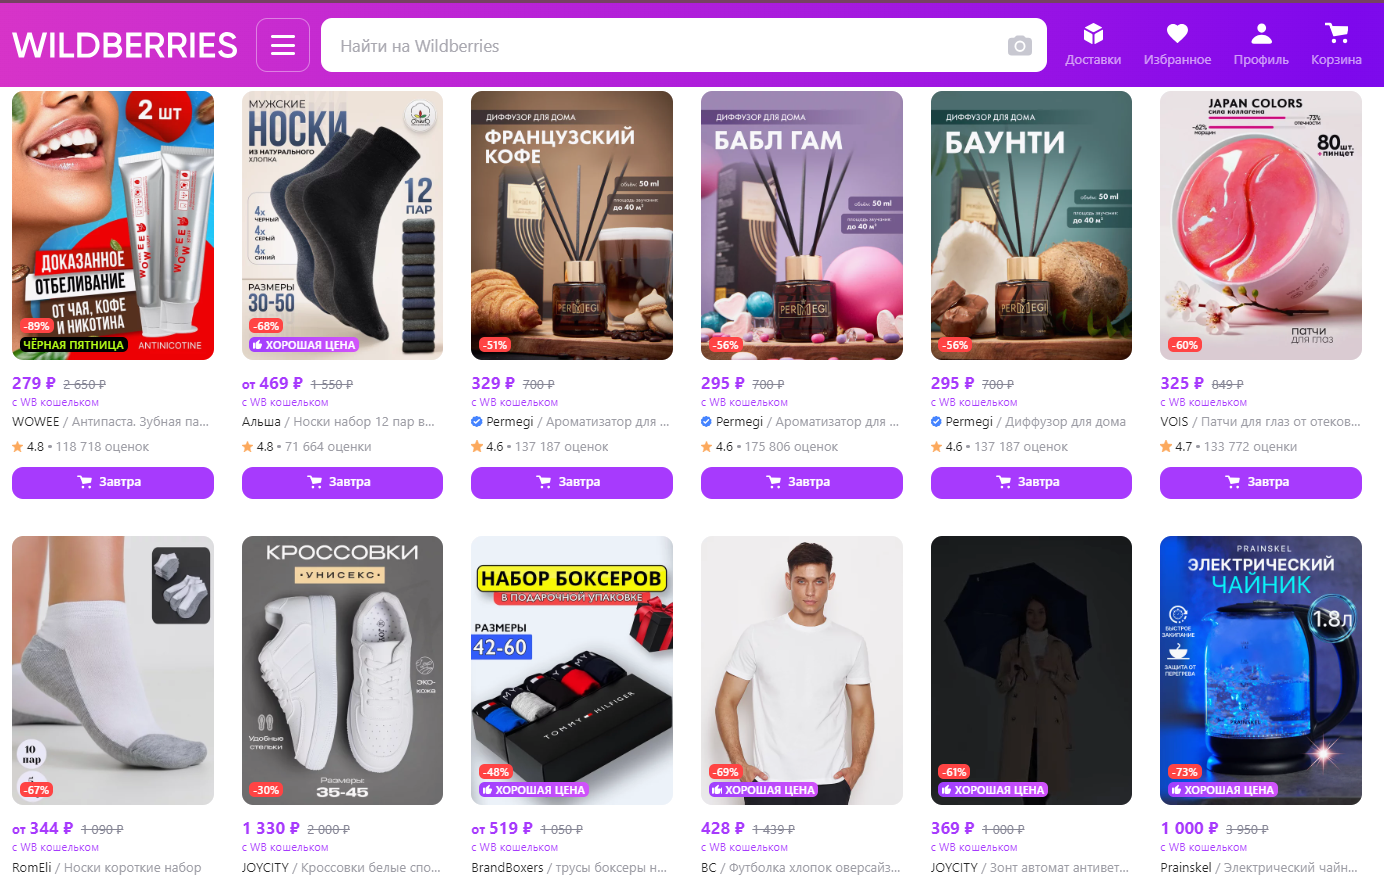

Для рекомендательной системы в таком случае, крайне важно предоставить релевантные предложения в топ 6-12 предложений. 6 - потому что это столько, сколько пользователь видит без каких либо действий, 12 - потому что столько пользователь увидит, когда начнет листать страницу. С большой вероятностью, если в первых 12 пользователь не найдет релевантных товаров, он не продолжит смотреть в список рекоммендаций, поэтому рассматривать модели @k где k > 12 кажется не оптимальным. Стоит понимать, что для большинства пользователей в датасете будет всего 1-3 взаимодействия, следовательно также будет справедливо оценивать k=3.

## Нам требуется выбрать метрики для наших моделей.

Основываясь на статье Setting Goals and Choosing Metrics for Recommender
System Evaluations (прикрепил в конце в источники), в нашем случае фидбек explicit (явный) и unary (мы знаем, когда товар интересен покупателю, но не знаем, когда товар ему не интересен, мы можем только гадать). Кажется, что регрессионные метрики здесь не подходят, так как нет оценок. В свою очередь, классификационные метрики игнорируют ранжирование, и дают хорошие оценки, при условии хороших наборов рекомендаций. В конце концов, ранжирующие метрики учитывают последовательность предложенных товаров, что критически важно для e-commerce кейсов.

### Sequential (Bert4Rec, Gru4Rec, ...)
Стоит заметить, что Sequential модели, сразу выдают какой-то вариант ранжирования, так как последним слоем стоит softmax, который выдает мягкие веса - вероятности для пользователя. Можно предпологать, что вероятности являются хорошим индикатором ранга. Значит для них можно сразу брать метрику, которая оценивает ранжирование

### Matrix Factorization (ALS, SVD, ...)
Алгоритмы матричной факторизации могут обучаться сразу на ранжирующей функции потерь, например как на LambdaRank. Алгоритмы матричной факторизации в таком случае будут авто-ранжировать свои рекомендации. Значит метрика для ранжирования будет справедливой.

### I2I & U2U подходы
Данные подходы обычно используют подход Nearest Neigbour, после получения эмбеддингов наших объектов, можно делать предсказания, находя ближайшие объекты к объектам в нашей последовательности. В данном случае ранжирующая функция - функция расстояния, следовательно метрика ранжирования будет использована.

### Popularity-Based
Популярные товары не нужно оценивать метрикой вероятно, так как здесь особо нечего выбирать из параметров модели.

### Re-Ranking
После этого можно собрать воедино предсказания с данных моделей и обучить ранжирующий алгоритм (например CatBoost).

### Итоги
Нам потребуется метрика для базовых моделей и для reranking модели. Так как у нас нет оцененных релевантностей (graded relevance), NDCG кажется не актуальным методом. В таком случае, можно использовать MAP@6 и MAP@12 для всех моделей.

$$
MAP@k = \sum_{i=1}^k prec(i) * I(elem_i ∈ test)
$$

В этом случае, precision - это доля истинно релевантных элементов из k самых релевантных предсказанных элементов.

MAP@k способен оценивать ранжирующую составляющую и присваивать больший вес айтемам, которые отранжированы правильнЕЕ и являются актуальными

# Prerequisites

In [1]:
!pip install polars loguru lightfm colorama>=0.4.4 catboost -q 

In [2]:
# !git clone https://github.com/RUCAIBox/RecBole.git -q && cd RecBole && pip install -eq . --verbose

Using pip 23.3.2 from /opt/conda/lib/python3.10/site-packages/pip (python 3.10)
ERROR: q is not a valid editable requirement. It should either be a path to a local project or a VCS URL (beginning with bzr+http, bzr+https, bzr+ssh, bzr+sftp, bzr+ftp, bzr+lp, bzr+file, git+http, git+https, git+ssh, git+git, git+file, hg+file, hg+http, hg+https, hg+ssh, hg+static-http, svn+ssh, svn+http, svn+https, svn+svn, svn+file).


In [3]:
!pip index versions recbole && pip index versions polars

recbole (1.2.0)
Available versions: 1.2.0, 1.1.1, 1.1.0, 1.0.1, 1.0.0, 0.2.1, 0.1.2, 0.1.1, 0.1.0
polars (0.20.23)
Available versions: 0.20.23, 0.20.22, 0.20.21, 0.20.19, 0.20.18, 0.20.17, 0.20.16, 0.20.15, 0.20.14, 0.20.13, 0.20.10, 0.20.9, 0.20.8, 0.20.7, 0.20.6, 0.20.5, 0.20.4, 0.20.3, 0.20.2, 0.20.1, 0.20.0, 0.19.19, 0.19.18, 0.19.17, 0.19.15, 0.19.14, 0.19.13, 0.19.12, 0.19.11, 0.19.7, 0.19.6, 0.19.5, 0.19.3, 0.19.2, 0.19.1, 0.19.0, 0.18.15, 0.18.13, 0.18.12, 0.18.11, 0.18.8, 0.18.7, 0.18.6, 0.18.4, 0.18.3, 0.18.2, 0.18.0, 0.17.15, 0.17.14, 0.17.13, 0.17.12, 0.17.11, 0.17.10, 0.17.9, 0.17.5, 0.17.3, 0.16.18, 0.16.16, 0.16.15, 0.16.14, 0.16.13, 0.16.12, 0.16.11, 0.16.10, 0.16.9, 0.16.8, 0.16.7, 0.16.6, 0.16.5, 0.16.4, 0.16.3, 0.16.2, 0.16.1, 0.15.18, 0.15.17, 0.15.16, 0.15.15, 0.15.14, 0.15.13, 0.15.11, 0.15.9, 0.15.8, 0.15.7, 0.15.6, 0.15.2, 0.15.1, 0.14.29, 0.14.28, 0.14.27, 0.14.26, 0.14.25, 0.14.24, 0.14.23, 0.14.21, 0.14.19, 0.14.18, 0.14.17, 0.14.14, 0.14.11, 0.14.10, 0.14.9,

In [4]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


import numpy as np
import polars as pl
import pandas as pd
import dill
import scipy
from __future__ import annotations
from datetime import datetime as dt


from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from scipy.sparse import csr_matrix, coo_matrix
from polars.testing import assert_frame_equal
from typing import Tuple, Iterable, Dict
from scipy import sparse as sp
from loguru import logger
from polars.type_aliases import SchemaDefinition
from numpy.random import shuffle

from abc import ABC, abstractmethod
from scipy.sparse import csr_matrix


In [5]:
"""

# Load the Drive helper and mount
from google.colab import drive
drive_path = '/content/drive'
drive.mount(drive_path)

drive_path += "/MyDrive"
data_path = drive_path + "/preprocessed_users_data.csv"
"""
data_path = "/kaggle/input/preproc-data/preprocessed_users_data.csv"

def set_seed(seed: int = 42) -> None:
    import random
    import os

    np.random.seed(seed)
    random.seed(seed)
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

    return seed

set_seed()

Random seed set as 42


42

In [6]:
data = pl.read_csv(data_path)

In [7]:
data = data.with_columns(order_ts = data["order_ts"].str.to_datetime())
data.head()

,user_id,item_id,order_ts
i64,i64,i64,datetime[μs]
0,550614,264,2023-01-01 00:28:09
1,571051,580,2023-01-01 00:41:47
2,571051,180,2023-01-01 00:41:47
3,47164,5135,2023-01-01 00:53:35
4,219072,2668,2023-01-01 01:02:29


# Train Test Split

In [8]:
data["order_ts"].min(), data["order_ts"].max()

(datetime.datetime(2023, 1, 1, 0, 0, 5),
 datetime.datetime(2023, 3, 31, 23, 59, 59, 947831))

## Global Train Test

In [9]:
global_split = dt(year=2023,month=3,day=15)
train_global = data.filter(pl.col("order_ts") < global_split ) # first 75 days
test_global = data.filter(pl.col("order_ts") >= global_split ) # last 15 days

In [10]:
train_global.shape, test_global.shape

((15453549, 4), (3805738, 4))

## Base Train / Validation / Predict

In [11]:
train_rerank_split = dt(year=2023,month=3,day=1)
base_data = data.filter(pl.col("order_ts") < train_rerank_split ) # first 60 days
candidate_predict_set = data.filter(pl.col("order_ts") >= train_rerank_split) # [60, 75] days

base_model_split = dt(year=2023,month=2,day=20)
train_base = data.filter(pl.col("order_ts") < base_model_split) # first 50 days
val_base = data.filter(pl.col("order_ts") >= base_model_split)  # [50, 60] days
train_val_base = base_data

In [12]:
train_base.shape, val_base.shape, candidate_predict_set.shape

((10064834, 4), (9194453, 4), (7167821, 4))

## Rerank Train / Test

In [13]:
# First, get a unique list of users
users = candidate_predict_set['user_id'].unique()

# Split users into train and test sets
users_train, users_test = train_test_split(users, test_size=0.2, random_state=42)

# Filter the rows of the DataFrame based on the split user sets
df = candidate_predict_set
train_rerank = df.filter(pl.col("user_id").is_in(users_train))
test_rerank = df.filter(pl.col("user_id").is_in(users_test))

In [14]:
train_rerank.shape, test_rerank.shape

((5737391, 4), (1430430, 4))

In [15]:
debug_set = train_global = data.filter(pl.col("order_ts") <  dt(year=2023,month=1,day=3) ) # first 2 days

In [16]:
del df

## Dataset Palette

In [17]:
# Итого вот наши датасеты:
train_global, test_global
train_base, val_base, train_val_base, candidate_predict_set
train_rerank, test_rerank;

<img src=attachment:0f788f97-a82a-458b-bab7-631473882c18.png width="700">
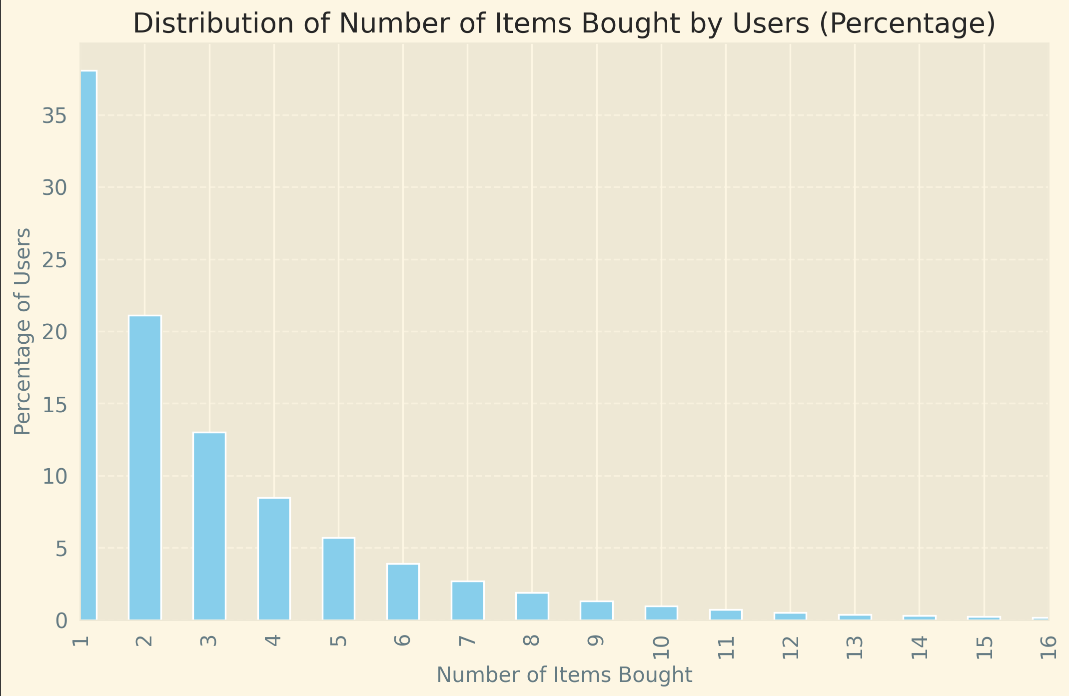

Базируясь на этом распределении, будем поступать так: 
пусть каждая модель тренируется и предсказывает на пользователях с 1 покупкой. Да, эти пользователи будут ухудшать метрики. Однако будет симулировать проблему холодного старта. Такие условия похожи на настоящие


# Sparse Matrix

In [18]:
def long_to_wide(df: pl.DataFrame) -> pl.DataFrame:
    df = df.with_columns(
        interacted=pl.lit(1),  # Set all interactions to 1 initially
    )
    df.with_columns(pl.col("interacted").cast(pl.Int8))

    pivot = df.pivot(index='user_id', columns='item_id', values='interacted', aggregate_function="sum")
    return pivot

def wide_to_csr(df: pl.DataFrame) -> csr_matrix:
    arrow_array = df.to_arrow()
    values = arrow_array.to_pandas().values
    return csr_matrix(values)

def long_to_csr(df: pl.DataFrame) -> (csr_matrix, (np.array, np.array)):
    # Get unique user and item IDs
    users = df['user_id'].unique().to_list()
    items = df['item_id'].unique().to_list()

    # Create mapping from user/item ID to row/column index
    user_to_row = {user: i for i, user in enumerate(users)}
    item_to_col = {item: i for i, item in enumerate(items)}

    # Create data, row indices, and column indices for the CSR matrix
    data = [1] * len(df)
    row_indices = [user_to_row[user] for user in df['user_id']]
    col_indices = [item_to_col[item] for item in df['item_id']]

    # Create the CSR matrix
    csr = csr_matrix((data, (row_indices, col_indices)), 
                     shape=(len(users), len(items)),
                     dtype=np.int8)

    return csr, (np.array(users).flatten(), np.array(items).flatten())

### Test long_to_wide, wide_to_csr functions

In [19]:
wide = long_to_wide(test_rerank.head(10000))
csr = wide_to_csr(wide)

df = pl.DataFrame(csr.toarray(),)
df.columns=wide.columns
df = df.fill_nan(None)

assert_frame_equal(wide, df,check_dtype=False)

## Sparse matrix row to bought items

In [20]:
# from functools import lru_cache


# Wall time: 2.86 ms
def user_purchases_from_sparse(sparse_data: csr_matrix, item_ids: np.array, user_index: int) -> Tuple[np.array, np.array]:
    raise Exception("Deprecated")
    
    user_interactions = sparse_data[user_index, :]
    interaction_mask = user_interactions != 0
    indices = sp.find(interaction_mask)[1]
    item_ids_of_user = np.array(item_ids)[indices]
    n_purchases = np.asarray(user_interactions[interaction_mask]).flatten()
    
    return item_ids_of_user, n_purchases

# Wall time: 527 µs
def user_purchases_from_sparse_optimized(sparse_data: csr_matrix, item_ids: np.array, user_index: int, return_index=False) -> Tuple[np.array, np.array]:
    user_interactions = sparse_data.getrow(user_index)
    user_interactions_dense = user_interactions.toarray().flatten()
    indices = np.where(user_interactions_dense != 0)[0]
    n_purchases = user_interactions_dense[indices]
    if return_index:
        return indices, n_purchases
    
    item_ids_of_user = item_ids[indices]
    return item_ids_of_user, n_purchases

def all_user_purchases_from_sparse(sparse_data: csr_matrix, item_ids: np.array,):
    all_user_purchases = []
    for user_index in range(sparse_data.shape[0]):
        item_ids_of_user, n_purchases = user_purchases_from_sparse_optimized(sparse_data, item_ids, user_index)
        all_user_purchases.append(item_ids_of_user)
    return all_user_purchases    

# Core Model Class

```
Вопрос: 
Для пользователей возвращаются индексы или id?
Индексы - пользователи, пронумерованые от 0 до n-1 
моделью
id - реальный id в базе wildberries 

мы хотим использовать в предсказаниях и работе 
реальный id wildberries, поэтому надо убедится, что
каждый класс возвращает id
```

In [21]:
class BaseModel(ABC):
    @abstractmethod
    def fit(self, sparse_data: csr_matrix, item_ids: np.array, user_ids: np.array) -> 'BaseModel':
        """
        Fit the model to the data.

        Parameters:
        - sparse_data: A sparse matrix representing user-item interactions (number of purchases).
        - item_ids: An array of item IDs.
        - user_ids: An array of user IDs.

        Returns:
        A reference to the fitted model instance.
        """
        pass
    
    @abstractmethod
    def predict(self, user_ids: np.array) -> np.array:
        """
        Predict the ranking scores for a given array of user IDs.

        Parameters:
        - user_ids: An array of user IDs for whom predictions are to be made.

        Returns:
        N_USERS x N_ITEMS Rank Array
        """
        pass
    
    def _create_user_ids_to_user_index_map(self, user_ids: Iterable):
        return self._ids_to_index_map(user_ids)
    
    def _create_item_ids_to_item_index_map(self, item_ids: Iterable):
        return self._ids_to_index_map(item_ids)
    
    def _ids_to_index_map(self, ids: Iterable):
        n_ids = len(ids)
        return dict( zip(ids, range(n_ids)) )

## Sparse Dataset Palette

In [22]:
train_val_base_csr, (tv_user_ids, tv_item_ids) = long_to_csr(train_val_base)
cand_pred_csr, (cp_user_ids, cp_item_ids) = long_to_csr(candidate_predict_set)
debug_set_csr, (user_ids, item_ids) = long_to_csr(debug_set)

# Baseline

In [23]:
debug_set_coo = debug_set_csr.tocoo()

In [24]:
user_ids

array([     42,      44,      55, ..., 1057241, 1057245, 1057248])

## Popularity

In [25]:
class PopModel(BaseModel):
    def __init__(self):
        self.ranks = None
        self.n_items = None
    
    def fit(self, sparse_data: csr_matrix, item_ids: np.array, user_ids: np.array) -> PopModel:
        _ = user_ids
        assert sparse_data.shape == ( len(user_ids), len(item_ids) )
        self.n_items = len(item_ids)
        
        total_purchases = sparse_data.sum(axis=0)
        popularity_sorted_args = total_purchases.argsort()[:, ::-1]
        popularity_sorted_index = np.squeeze(np.asarray(popularity_sorted_args))
        total_purchases = np.squeeze(np.asarray(total_purchases))

        self.ranks = n_purchases = total_purchases[popularity_sorted_index]
        
        return self

    def predict(self, user_ids: np.array | Iterable) -> np.ndarray:
        """
        Here we get same list of items for any user_ids, because it is Baseline.
        Returns N_USERS X N_ITEMS
        """
        n_users = len(user_ids)
        n_items = self.n_items
        
        ranks = self.ranks
        ranks_repeated = np.tile(ranks, (n_users, 1))
        
        assert ranks_repeated.shape == (n_users, n_items)
        return ranks_repeated

In [26]:
# pop_model = PopModel().fit(train_base_csr)
# pop_items = pop_model.predict(tb_item_ids)

pop_model = PopModel().fit(debug_set_csr, item_ids, user_ids)
pop_items = pop_model.predict(user_ids)
print("Popularity ordered, descending: ", pop_items)

print("\n1st, 2nd, last:")
print(train_base.filter(pl.col("item_id") == 192).shape)
print(train_base.filter(pl.col("item_id") == 390).shape)
print(train_base.filter(pl.col("item_id") == 8384).shape)

del pop_model

Popularity ordered, descending:  [[6594 4472 4197 ...    1    1    1]
 [6594 4472 4197 ...    1    1    1]
 [6594 4472 4197 ...    1    1    1]
 ...
 [6594 4472 4197 ...    1    1    1]
 [6594 4472 4197 ...    1    1    1]
 [6594 4472 4197 ...    1    1    1]]

1st, 2nd, last:
(199677, 4)
(165808, 4)
(1, 4)


## Historical

In [27]:
class UserHistoryModel(BaseModel):
    def __init__(self, chunk_size=10000):
        self.train_data = None
        self.user_ids_to_index = {}
        self.chunk_size = chunk_size  # Adjust the chunk size based on available memory and performance

        
    def fit(self, sparse_data: csr_matrix, item_ids: np.array, user_ids: np.array) -> UserHistoryModel:
        """
        This model must collect most popular items for every user
        """
        assert sparse_data.shape == ( len(user_ids), len(item_ids) )
        # it is itself ranks matrix
        self.train_data = sparse_data
        self.user_ids_to_index = self._create_user_ids_to_user_index_map(user_ids)
        return self

        
    def predict(self, user_ids: np.array) -> np.ndarray:
        """
        Returns N_USERS X N_ITEMS
        """
        user_indices = [self.user_ids_to_index.get(id_) for id_ in user_ids]
        user_indices = np.array(user_indices)

        # Deal with Cold Start, Just return 0 vectors
        mask = user_indices != None
        user_data = np.zeros(shape=(len(user_indices), self.train_data.shape[1]))  # Initialize with zeros
        
        logger.debug("Shapes: \n")
        logger.debug(f"mask.shape: {mask.shape}")
        logger.debug(f"user_data.shape: {user_data.shape}")
        logger.debug(f"self.train_data.shape: {self.train_data.shape}")
        logger.debug(f"user_indices.shape: {user_indices.shape}")
        
        chunk_size = self.chunk_size
        num_chunks = len(user_indices) // chunk_size + 1

        for i in range(num_chunks):
            start_idx = i * chunk_size
            end_idx = min((i + 1) * chunk_size, len(user_indices))
            
            user_indices_chunk = user_indices[mask][start_idx:end_idx]
            user_data_chunk = self.train_data[user_indices_chunk, :].toarray()

            if len(user_indices_chunk) < end_idx - start_idx:
                end_idx = start_idx + len(user_indices_chunk)
                
            mask_chunk = mask[start_idx:end_idx]

            if user_data_chunk.shape[0] != mask_chunk.shape[0]:
                logger.debug(f"user_data_chunk.shape: {user_data_chunk.shape}, mask_chunk.shape: {mask_chunk.shape}")
            
            user_data[start_idx:end_idx, :][mask_chunk] = user_data_chunk[mask_chunk]

        return user_data

In [28]:
historical_model = UserHistoryModel().fit(debug_set_csr, np.array(item_ids), np.array(user_ids))

hist_predictions_ranks = historical_model.predict(user_ids)
hist_predictions_ranks[hist_predictions_ranks > 0]

del historical_model

2024-04-30 09:28:37.520 | DEBUG    | __main__:predict:30 - Shapes: 

2024-04-30 09:28:37.522 | DEBUG    | __main__:predict:31 - mask.shape: (118989,)
2024-04-30 09:28:37.523 | DEBUG    | __main__:predict:32 - user_data.shape: (118989, 4367)
2024-04-30 09:28:37.524 | DEBUG    | __main__:predict:33 - self.train_data.shape: (118989, 4367)
2024-04-30 09:28:37.525 | DEBUG    | __main__:predict:34 - user_indices.shape: (118989,)


array([1., 1., 1., ..., 2., 1., 1.])

# Advanced Model

Здесь я реализую ансамбль рекомендующих моделей, в него будут включены: 
* Popular Baseline + 
* Historical Baseline + 
* User-to-User +
* ALS / LightFM / SVD +
* Sequential (LSTM4Rec, GRU4Rec, Bert4Rec)

## LightFM

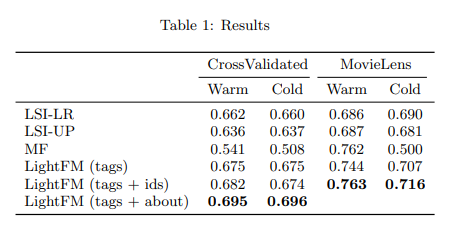

In [29]:
from lightfm import LightFM
from lightfm.evaluation import precision_at_k as lightfm_precision_at_k

class MatrixFactorization(BaseModel):
    def __init__(self, n_latent=10, model_class=LightFM, precision=lightfm_precision_at_k) -> MatrixFactorization:
        # Используем warp так как это лучший лосс для кейсов, когда только положительные взаимодействия в датасете
        self.model = model_class(loss="warp", no_components=n_latent)
        self.precision = lightfm_precision_at_k
        self.item_ids_fitted = None
        # num_threads=4 потому что у Kaggle 4 ядер.
        self.num_threads=4
    
    def fit(self, sparse_data: coo_matrix, item_ids: np.array, user_ids: np.array, epochs=1) -> MatrixFactorization:
        assert sparse_data.shape == ( len(user_ids), len(item_ids) )
        
        self.user_id_to_index = self._create_user_ids_to_user_index_map(user_ids)
        self.item_id_to_index = self._create_item_ids_to_item_index_map(item_ids)
        self.item_ids_fitted = item_ids

        %time self.model.fit(sparse_data, epochs=epochs, num_threads=self.num_threads)
        return self
    
    def predict(self, user_ids: np.array) -> np.ndarray:
        """
        Returns np.ndarray of shape N_USERS X N_ITEMS
        """
        # Lets set 0 as unknown id (Cold Start)
        user_indices = np.array([self.user_id_to_index.get(uid, 0) for uid in user_ids])
        item_indices = np.array([self.item_id_to_index.get(iid, 0) for iid in self.item_ids_fitted])
        
        n_users = len(user_indices)
        n_items = len(item_indices)

        repeated_user_indices = np.tile(user_indices.reshape(-1, 1), (1, n_items))
        repeated_user_indices = repeated_user_indices.astype(int)
        predictions = np.empty((n_users, n_items))
        
        for u in range(n_users):
            # [u_1, u_1,......]
            # [...............]
            # [u_n, u_n, .....]
        
            user_indices_repeated = repeated_user_indices[u, :]
            ranks_predicted = self.model.predict(user_indices_repeated, item_indices)
            predictions[u, :] = ranks_predicted
            
        return predictions
    
    def get_latent_users(self):
        return self.model.user_embeddings 
    
    def evaluate(self, test_data: csr_matrix, k=3):
        prec = self.precision(self.model, test_data, k=k)
        print(f"Train precision at {k}: %.2f" % prec.mean())
        return prec

In [30]:
mf_model = MatrixFactorization().fit(debug_set_csr, item_ids, user_ids, epochs=1)
test_preds = mf_model.predict(user_ids[:10])
mf_model.evaluate(debug_set_coo)
user_emb = mf_model.get_latent_users()
print(user_emb[:3])

del mf_model

CPU times: user 532 ms, sys: 3.88 ms, total: 536 ms
Wall time: 165 ms
Train precision at 3: 0.04
[[ 0.11102809 -0.00955062 -0.00060277 -0.01012897 -0.06874805 -0.07551765
  -0.02944469  0.06990459  0.05725013 -0.00206197]
 [ 0.02212125 -0.04626891 -0.0362025   0.01494024 -0.0415432  -0.02687372
   0.03063741 -0.05088987 -0.00016581 -0.01805767]
 [-0.00743323  0.03382621 -0.01224683 -0.00922953 -0.03846272 -0.05678099
   0.01247651  0.03203491 -0.05472299 -0.046085  ]]


In [31]:
user_emb.shape

(118989, 10)

## User-to-User

In [32]:
# as NN already uses Approximate Nearest Neighbour, we will utilize this
from sklearn.neighbors import NearestNeighbors

class User2User(BaseModel):
    def __init__(self, metric="cosine", n_jobs=-1, n_neighbors=2):
        self.model = NearestNeighbors(n_neighbors=n_neighbors, radius=1, metric=metric, n_jobs=n_jobs)
        self.sparse_data_fitted = None
        self.item_ids = None
        self.user_ids = None
        self.user_id_to_index = {}
        self.user_embeddings = None
        
    def fit(self, sparse_data: csr_matrix, item_ids: Iterable, user_ids: Iterable, user_embeddings: np.ndarray):
        assert sparse_data.shape == ( len(user_ids), len(item_ids) )
        
        self.sparse_data_fitted = sparse_data
        self.item_ids = item_ids
        self.user_ids = user_ids
        self.user_id_to_index = self._create_user_ids_to_user_index_map(user_ids)
        
        # add zero row for unknown users (cold start)
        zero_row = np.zeros((1, user_embeddings.shape[1]))
        self.user_embeddings = np.vstack((user_embeddings, zero_row))
        
        logger.info(f"{user_embeddings.shape[0]} users to estimate left...")
        self.model.fit(user_embeddings)
        logger.info(f"Done.")
        return self
    
    def predict(self, user_ids: Iterable):
        user_indices = np.array([self.user_id_to_index.get(uid, -1) for uid in user_ids])
        user_embeddings = self.user_embeddings[user_indices]

        dist, similar_users_index_matrix = self.model.kneighbors(user_embeddings, return_distance=True)
        
        all_users_ranks = np.zeros((len(user_ids), len(self.item_ids)))
        rank_positions = 1 / (np.arange(len(similar_users_index_matrix[0])) + 1)
        
        for i, similar_users in enumerate(similar_users_index_matrix):
            if i % 100000 == 0:
                logger.debug(f"{i} Users processed out of {similar_users_index_matrix.shape[0]}")
            ranks_for_user = self._find_and_rank_neighbors(similar_users, rank_positions)
            all_users_ranks[i, :] = ranks_for_user
        
        return all_users_ranks

    def _find_and_rank_neighbors(self, similar_users: np.array, rank_positions: np.array):
        ranks_for_users = np.zeros((len(similar_users), len(self.item_ids)))
        
        for i, similar_user_index in enumerate(similar_users):
            similar_user_item_indices, n_purchases = self._get_user_items_and_ranks(similar_user_index)
            ranks_for_users[i, similar_user_item_indices] = n_purchases * rank_positions[i]
        
        return np.sum(ranks_for_users, axis=0)

    def _get_user_items_and_ranks(self, user_index: int):
        similar_user_item_indices, n_purchases = user_purchases_from_sparse_optimized(self.sparse_data_fitted, self.item_ids, user_index, return_index=True)
        return similar_user_item_indices, n_purchases.flatten()

# Wall time 3:40
%time knn_model = User2User().fit(debug_set_csr, item_ids, user_ids, user_emb)
%time ranks = knn_model.predict(user_ids[:10])
del knn_model, ranks

2024-04-30 09:29:04.067 | INFO     | __main__:fit:25 - 118989 users to estimate left...
2024-04-30 09:29:04.072 | INFO     | __main__:fit:27 - Done.


CPU times: user 32.6 ms, sys: 12.9 ms, total: 45.6 ms
Wall time: 46.7 ms
CPU times: user 51 ms, sys: 51 ms, total: 102 ms
Wall time: 105 ms


Все сходится, рекомендуются резонно:

In [33]:
for r in ranks[:3]:
    print(item_ids[np.where(r > 0)])

[203 297]
[1855 2940]
[ 133  212  295 5517]


In [34]:
# debug_set_csr[0,:]
for item_index in range(3):
    print(user_purchases_from_sparse_optimized(debug_set_csr, item_ids, item_index) )

(array([297]), array([1], dtype=int8))
(array([1855]), array([1], dtype=int8))
(array([ 133,  212, 5517]), array([1, 1, 1], dtype=int8))


## Sequential

* GRU4RECKG - работает на knowledge graphs
* GRU4RECF - работает на feature-rich данных
* LSTM4REC - требует мощностей
* BERT4REC - требует в среднем длинных взаимодействий и очень много данных
* GRU4REC - в таком случае, будет лучшим вариантом, так как эта реализация очень эффективная

In [35]:
train_base.head()

,user_id,item_id,order_ts
i64,i64,i64,datetime[μs]
0,550614,264,2023-01-01 00:28:09
1,571051,580,2023-01-01 00:41:47
2,571051,180,2023-01-01 00:41:47
3,47164,5135,2023-01-01 00:53:35
4,219072,2668,2023-01-01 01:02:29


In [36]:
def prepare_atomic_data(data: pl.DataFrame):
    data = data.rename({"user_id": "user_id:token", 
                                "item_id": "item_id:token",
                                "order_ts": "timestamp:float"}).to_pandas()
    data['timestamp:float'] = data["timestamp:float"].values.astype(np.int64) // 10 ** 9
    data = data.drop(columns=[""])
    data.head()
    
    !mkdir /kaggle/working/recbox_data
    data.to_csv('/kaggle/working/recbox_data/recbox_data.inter', index=False, sep='\t')


def run_gru4rec():
    import torch
    import os
    import sys
    from recbole.quick_start import run_recbole
    from recbole.quick_start.quick_start import load_data_and_model
    
    prepare_atomic_data(train_base)

    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
    print( torch.cuda.device_count() )
    
    print(torch.cuda.device_count())
    for i in range(torch.cuda.device_count()):
        print(torch.cuda.get_device_properties(i).name)
    
    sys.path.append('/Recbole')

    parameter_dict = {
        'data_path': '/kaggle/working',
        'train_neg_sample_args': None,
        'USER_ID_FIELD': 'user_id',
        'ITEM_ID_FIELD': 'item_id',
        'TIME_FIELD': 'timestamp',
        'load_col': {'inter': ['user_id', 'item_id', 'timestamp']},
        'neg_sampling': None,
        'epochs': 1,
        'gpu_id': "0,1",
        'train_batch_size': 2048 * 2,
        'leave_one_num': 2,
        'group_by_user': True,
    }

    np.int = int
    np.float = float
    run_recbole(model='GRU4Rec', dataset='recbox_data', config_dict=parameter_dict)
    

    config, gru4rec, dataset, train_data, valid_data, test_data = load_data_and_model(
        model_file='saved/GRU4Rec-Apr-24-2024_20-17-46.pth',
    )

In [37]:
"""
rnd_user = 550614

train_base = train_base.with_columns(label=pl.lit(0))

user_intr = train_base.filter(pl.col("user_id") == rnd_user)[["user_id", "item_id"]].copy()
user_intr = user_intr.with_columns(label=pl.lit(1))

print(user_intr.shape)

other_unique_items = train_base.unique()
other_unique_items = set( train_base["item_id"].unique().to_list() )
this_user_items = set(user_intr["item_id"].unique().to_list() )
other_unique_items = list(other_unique_items - this_user_items)
n_other = len(other_unique_items)

other_items = pl.DataFrame({"user_id": [rnd_user] * n_other, "item_id": other_unique_items, "label": [0] * n_other}, 
                           schema={"user_id": pl.Int64,"item_id": pl.Int64, "label": pl.Int32})

user_intr_with_neg = pl.concat([user_intr, other_items])
user_intr_with_neg = user_intr_with_neg.with_columns(pl.col('label').cast(pl.Int64, strict=True))
"""

'\nrnd_user = 550614\n\ntrain_base = train_base.with_columns(label=pl.lit(0))\n\nuser_intr = train_base.filter(pl.col("user_id") == rnd_user)[["user_id", "item_id"]].copy()\nuser_intr = user_intr.with_columns(label=pl.lit(1))\n\nprint(user_intr.shape)\n\nother_unique_items = train_base.unique()\nother_unique_items = set( train_base["item_id"].unique().to_list() )\nthis_user_items = set(user_intr["item_id"].unique().to_list() )\nother_unique_items = list(other_unique_items - this_user_items)\nn_other = len(other_unique_items)\n\nother_items = pl.DataFrame({"user_id": [rnd_user] * n_other, "item_id": other_unique_items, "label": [0] * n_other}, \n                           schema={"user_id": pl.Int64,"item_id": pl.Int64, "label": pl.Int32})\n\nuser_intr_with_neg = pl.concat([user_intr, other_items])\nuser_intr_with_neg = user_intr_with_neg.with_columns(pl.col(\'label\').cast(pl.Int64, strict=True))\n'

## Model Ensemble

In [38]:
class ModelEnsemble:
    def __init__(self):
        self.pop_model = PopModel()
        self.history_model = UserHistoryModel()
        self.mf_model = MatrixFactorization()
        self.knn_model = User2User(n_neighbors=2)
        
        self.models = {
            "Popularity Based Model": self.pop_model,
            "User History Model": self.history_model,
            "Matrix Factorization": self.mf_model,
            "User2User": self.knn_model,
        }
        
    def fit(self, data: coo_matrix, user_ids: Iterable, item_ids: Iterable) -> ModelEnsemble:
        simple_fit_models = [(k,v) for k,v in self.models.items() if k != "User2User"]
        assert data.shape == (len(user_ids), len(item_ids))
        
        for name, model in simple_fit_models:
            logger.info(f"Training model {name}")
            model.fit(data, user_ids=user_ids, item_ids=item_ids)
            
        user_embeddings = self.mf_model.get_latent_users()
        logger.info(f"Training model User2User")
        self.knn_model.fit(data, item_ids, user_ids, user_embeddings)
        
        return self
        
        
    def predict(self, user_ids: Iterable) -> Dict[str, np.ndarray]:
        # predictions = {"Model": ranks1, "Model2": ranks2, ...}
        predictions = {model_name: None for model_name in self.models.keys()}
        
        for name, model in self.models.items():
            logger.info(f"Inferencing model {name}")
            ranks_pred = model.predict(user_ids)
            
            predictions[name] = ranks_pred
        return predictions
    
    def __del__(self):
        for name, model in self.models.items():
            del model

### Scratch Testing

In [40]:
"""

ensemble = ModelEnsemble()
ensemble.fit(debug_set_csr, user_ids, item_ids)

preds = ensemble.predict(user_ids[:10])
list(preds.keys())

prediction_shapes = []
for name, prediction_of_model in preds.items():
    shape = prediction_of_model.shape
    prediction_shapes.append(shape)
    print(name,":", shape)

assert prediction_shapes.count(prediction_shapes[0]) == len(prediction_shapes), "Some models have wrong shape"

"""

2024-04-30 09:29:04.606 | INFO     | __main__:predict:35 - Inferencing model Popularity Based Model
2024-04-30 09:29:04.609 | INFO     | __main__:predict:35 - Inferencing model User History Model
2024-04-30 09:29:04.610 | DEBUG    | __main__:predict:30 - Shapes: 

2024-04-30 09:29:04.611 | DEBUG    | __main__:predict:31 - mask.shape: (10,)
2024-04-30 09:29:04.612 | DEBUG    | __main__:predict:32 - user_data.shape: (10, 4367)
2024-04-30 09:29:04.613 | DEBUG    | __main__:predict:33 - self.train_data.shape: (118989, 4367)
2024-04-30 09:29:04.614 | DEBUG    | __main__:predict:34 - user_indices.shape: (10,)
2024-04-30 09:29:04.617 | INFO     | __main__:predict:35 - Inferencing model Matrix Factorization
2024-04-30 09:29:04.627 | INFO     | __main__:predict:35 - Inferencing model User2User


['Popularity Based Model',
 'User History Model',
 'Matrix Factorization',
 'User2User']

For some reason, initially User History Model and User2User were defined incorrectly, and returned all users, that are known, instead of returning n requested. This is fixed now

### Final Ensemble

In [42]:
# Training on full 1-stage dataset
try: 
    del ensemble
except:
    pass

ensemble = ModelEnsemble().fit(train_val_base_csr, tv_user_ids, tv_item_ids)

2024-04-30 09:29:04.813 | INFO     | __main__:fit:20 - Training model Popularity Based Model
2024-04-30 09:29:04.886 | INFO     | __main__:fit:20 - Training model User History Model
2024-04-30 09:29:05.105 | INFO     | __main__:fit:20 - Training model Matrix Factorization
2024-04-30 09:29:12.320 | INFO     | __main__:fit:24 - Training model User2User


CPU times: user 23.6 s, sys: 199 ms, total: 23.8 s
Wall time: 7 s


2024-04-30 09:29:12.576 | INFO     | __main__:fit:25 - 941415 users to estimate left...
2024-04-30 09:29:12.583 | INFO     | __main__:fit:27 - Done.


In [44]:
# cand_pred_csr, (cp_user_ids, cp_item_ids)
fraction_size = int(len(cp_user_ids) * 0.05)
cp_user_ids_frac = np.random.choice(cp_user_ids, size=fraction_size)
candidate_predictions = ensemble.predict(cp_user_ids_frac)

2024-04-30 09:30:22.101 | INFO     | __main__:predict:35 - Inferencing model Popularity Based Model
2024-04-30 09:30:23.322 | INFO     | __main__:predict:35 - Inferencing model User History Model
2024-04-30 09:30:23.368 | DEBUG    | __main__:predict:30 - Shapes: 

2024-04-30 09:30:23.370 | DEBUG    | __main__:predict:31 - mask.shape: (41812,)
2024-04-30 09:30:23.371 | DEBUG    | __main__:predict:32 - user_data.shape: (41812, 6415)
2024-04-30 09:30:23.372 | DEBUG    | __main__:predict:33 - self.train_data.shape: (941415, 6415)
2024-04-30 09:30:23.374 | DEBUG    | __main__:predict:34 - user_indices.shape: (41812,)
2024-04-30 09:30:26.449 | INFO     | __main__:predict:35 - Inferencing model Matrix Factorization
2024-04-30 09:31:21.589 | INFO     | __main__:predict:35 - Inferencing model User2User


In [50]:
for model, ranks in candidate_predictions.items():
    np.save(f'{model}_ranks.npy', ranks)

In [51]:
!ls

'=0.4.4'			    'User History Model_ranks.npy'
'Matrix Factorization_ranks.npy'     User2User_ranks.npy
'Popularity Based Model_ranks.npy'


## Second Stage (CatBoost)

### Data Preprocessing

Как мы формируем выборку для catboost?
Тренируем на задачу классификации. На каждую пару user-item (+/-), должны быть ранги всех моделей по этой паре.

Изначально можно собрать все взаимодействия, которые правда были и собрать ранги из моделей. Благо каждый датасет с предсказаниями выдает
предсказания именно в таком порядке, в котором они были запрошены, следовательно простым индексированием row-column можно получить любые ранги
на любую пару пользователя и айтема для любой модели, это стоит организовать в функцию.

In [ ]:
pop_ranks = preds['Popularity Based Model']
hist_ranks = preds['User History Model']
mf_ranks = preds['Matrix Factorization']
knn_ranks = preds['User2User']

all_ranks = [pop_ranks, hist_ranks, mf_ranks, knn_ranks]

In [ ]:
user_ids, item_ids

### get_positive_samples Function

In [52]:
def get_rank_for_pair_index(user_index: int, item_index: int, ranks: np.ndarray) -> float:
    """
    Get the rank for a specific user-item pair from a model's prediction. Works only with all models except Sequential

    Parameters:
        user_index (int): Index of the user for whom to get the rank.
        item_index (int): Index of the item for which to get the rank.
        model_prediction (np.ndarray): Array of shape (2, N_USERS, N_ITEMS) containing candidates items and ranks.
    Returns:
        float: The rank of the given item for the specified user from row user_index and column item_index.
    """
    rank = ranks[user_index, item_index]
    if type(rank) == np.matrix:
        rank = np.array(rank)
    elif type(rank) in (csr_matrix, coo_matrix):
        rank = rank.toarray()
    else: 
        assert type(rank) == np.ndarray
        
    if rank.size == 0:
        return None
    return float( rank.flatten()[0] )
    

def get_rank_for_pair_ids(user_id: int, item_id: int, ranks: np.ndarray, 
                         user_ids: Iterable, item_ids: Iterable):
    """
    Get the rank for a specific user-item pair from a model's prediction. Works only with all models except Sequential

    Parameters:
        user_index (int): Index of the user for whom to get the rank.
        item_index (int): Index of the item for which to get the rank.
        model_prediction (np.ndarray): Array of shape (2, N_USERS, N_ITEMS) containing candidates items and ranks.
    Returns:
        float: The rank of the given item for the specified user from row user_index and column item_index.
    """
    user_index = np.where(user_ids==user_id)[0]
    item_index = np.where(item_ids==item_id)[0]
    
    return get_rank_for_pair_index(user_index, item_index, ranks)
    


In [53]:
def append_ranks(ranks: np.ndarray, df: pl.DataFrame, user_ids: Iterable, item_ids: Iterable, col_name: str) -> pl.DataFrame:
    user_col_index = 1
    item_col_index = 2
    
    rank_df = df.map_rows(
        lambda row: get_rank_for_pair_ids(row[user_col_index], row[item_col_index], ranks, user_ids, item_ids), 
        return_dtype=pl.Float32
   )
    return df.with_columns(rank_df.to_series().alias(col_name))

In [54]:
def get_positive_samples(df: pl.DataFrame, all_ranks: List[np.ndarray], user_ids: Iterable, item_ids, col_names: List[str]):
    """user_ids and item_ids should be taken from train, those have to be in ranks matrix as rows and columns"""
    df_known_users = df.filter(pl.col("user_id").is_in(user_ids))
    df_with_ranks = df_known_users
    
    for ranks, col_name in zip(all_ranks, col_names):
        df_with_ranks = append_ranks(ranks, df_with_ranks, user_ids, item_ids, col_name)
    df_with_ranks = df_with_ranks.with_columns(target=pl.lit(1))
    
    return df_with_ranks

In [ ]:
some_users = user_ids[:5]
some_items = item_ids[:5]

for item_id, user_id in zip(some_items, some_users):
    some_ranks = [get_rank_for_pair_ids(user_id,item_id,ranks, user_ids, item_ids) for ranks in all_ranks]
    print(some_ranks)

In [ ]:
col_names = ["pop_rank", "hist_rank", "mf_rank", "knn_rank"]
debug_positive_with_ranks = get_positive_samples(debug_set, all_ranks, user_ids[:10], item_ids, col_names)
debug_positive_with_ranks.head()

### generate_negative_examples Function

In [70]:


def create_pos_memo(positive_df: pl.DataFrame, user_id: Iterable, item_id: Iterable):
    pos_user_ids = positive_df["item_id"]
    pos_item_ids = positive_df["user_id"]

    positive_examples_memo = {(user_id, item_id): True for user_id, item_id in zip(pos_user_ids, pos_item_ids)}
    return positive_examples_memo
    
def generate_negative_examples(user_ids: Iterable, item_ids: Iterable, 
                               positive_examples_memo: Dict[Tuple[int, int]: bool], 
                               all_ranks: List[np.ndarray], df_schema: SchemaDefinition, n=10):
    n_predicted_users = all_ranks[-1].shape[0]
        
#     assert n_predicted_users >= n, f"Cant generate so much samples: {n}, as predictions are presented only for {n_predicted_users}"
    
    user_ids = user_ids.copy()
    item_ids = item_ids.copy()
    shuffle(user_ids)
    shuffle(item_ids)

    n_items = item_ids.shape[0]
    negative_examples = np.empty( (n, 5 + len(all_ranks)) )
    j = 0
    
    while j < n:
        # if overflow occurs: n is bigger then number of users, then iterate through users again
        i = j % n_items
        if i == 0 or i % 25000 == 0:
            logger.info(f"{j} neg. samples generated our of {n}")
        uid, iid = user_ids[i], item_ids[i]

        if positive_examples_memo.get((uid, iid)) is True:
            n += 1
            logger.debug(f"{(uid, iid)} is found in positive samples, skipping")
            continue

        ranks_for_pair = []
        for ranks in all_ranks:
            rank = get_rank_for_pair_ids(uid, iid, ranks, user_ids, item_ids)
            ranks_for_pair.append(rank)

        # index, uid, iid, ts, [rank_1, ..., rank_n], target
        row = [0, uid, iid, 0] + ranks_for_pair + [0]
        negative_examples[i, :] = np.array(row)

        j += 1

    return pl.DataFrame(data=negative_examples, schema=df_schema, nan_to_null=True)

In [ ]:
df_schema = debug_positive_with_ranks.schema
pos_memo = create_pos_memo(debug_positive_with_ranks, user_ids, item_ids)
debug_negatives_with_rank = generate_negative_examples(user_ids, item_ids, pos_memo, all_ranks, df_schema, n=10)
debug_negatives_with_rank.head()

### CatBoost Training

#### Prepare Data

In [56]:
all_ranks = list(candidate_predictions.values())
col_names = ["pop_rank", "hist_rank", "mf_rank", "knn_rank"]

pos_neg_split = 0.66

pos = get_positive_samples(train_val_base, all_ranks, cp_user_ids_frac, cp_item_ids, col_names)
pos_dict = create_pos_memo(pos, cp_user_ids_frac, cp_item_ids)

n_positives = pos.shape[0]
n_negatives = int((1 - pos_neg_split) * n_positives)

logger.debug(f"pos.shape: {pos.shape}")
logger.debug(f"{n_negatives} negative samples will be sampled, %{1 - pos_neg_split}")

2024-04-30 09:56:10.619 | DEBUG    | __main__:<module>:12 - pos.shape: (542911, 9)
2024-04-30 09:56:10.621 | DEBUG    | __main__:<module>:13 - 184589 negative samples will be sampled, %0.33999999999999997


In [71]:
neg = generate_negative_examples(cp_user_ids_frac, cp_item_ids, pos_dict, all_ranks, pos.schema, n=n_negatives)
logger.debug(f"neg.shape: {neg.shape}")

# boost_data = pl.concat((pos, neg))
# boost_data.sample(5)

2024-04-30 10:13:44.560 | INFO     | __main__:generate_negative_examples:33 - 0 neg. samples generated our of 184589
2024-04-30 10:13:45.474 | INFO     | __main__:generate_negative_examples:33 - 6310 neg. samples generated our of 184589
2024-04-30 10:13:46.390 | INFO     | __main__:generate_negative_examples:33 - 12620 neg. samples generated our of 184589
2024-04-30 10:13:47.294 | INFO     | __main__:generate_negative_examples:33 - 18930 neg. samples generated our of 184589
2024-04-30 10:13:48.203 | INFO     | __main__:generate_negative_examples:33 - 25240 neg. samples generated our of 184589
2024-04-30 10:13:49.116 | INFO     | __main__:generate_negative_examples:33 - 31550 neg. samples generated our of 184589
2024-04-30 10:13:50.046 | INFO     | __main__:generate_negative_examples:33 - 37860 neg. samples generated our of 184589
2024-04-30 10:13:51.025 | INFO     | __main__:generate_negative_examples:33 - 44170 neg. samples generated our of 184589
2024-04-30 10:13:52.097 | INFO     | 

,user_id,item_id,order_ts,pop_rank,hist_rank,mf_rank,knn_rank,target
i64,i64,i64,datetime[μs],f32,f32,f32,f32,i32
0,0,0,1970-01-01 00:00:00,0.0,0.0,0.0,0.0,0
10325802,671054,347,2023-02-13 09:57:52.317167,11372.0,0.0,1.865591,0.0,1
8040693,247556,1444,2023-02-03 13:31:22.090337,1449.0,0.0,-1.835713,0.0,1
10264379,198838,2909,2023-02-12 10:48:01.636987,327.0,0.0,-1.750657,0.0,1
2522044,645374,1981,2023-01-09 10:58:27,765.0,0.0,-1.283293,0.0,1


In [85]:
display(pos.sample(5))
display(neg.sample(5))

,user_id,item_id,order_ts,pop_rank,hist_rank,mf_rank,knn_rank,target
i64,i64,i64,datetime[μs],f32,f32,f32,f32,i32
3214104,486086,291,2023-01-13 06:47:46,14009.0,0.0,-1.921427,0.0,1
5281325,745189,6208,2023-01-31 08:42:51.004166,14.0,0.0,-2.018124,0.0,1
3918169,450020,2795,2023-01-16 07:43:06,365.0,0.0,-1.228882,0.0,1
8694434,565787,385,2023-02-05 10:55:57,9510.0,0.0,0.657478,0.0,1
4923292,495764,944,2023-01-20 17:10:43.650778,2899.0,0.0,1.124087,0.0,1


,user_id,item_id,order_ts,pop_rank,hist_rank,mf_rank,knn_rank,target
i64,i64,i64,datetime[μs],f32,f32,f32,f32,i32
0,0,0,1970-01-01 00:00:00,0.0,0.0,0.0,0.0,0
0,0,0,1970-01-01 00:00:00,0.0,0.0,0.0,0.0,0
0,0,0,1970-01-01 00:00:00,0.0,0.0,0.0,0.0,0
0,0,0,1970-01-01 00:00:00,0.0,0.0,0.0,0.0,0
0,0,0,1970-01-01 00:00:00,0.0,0.0,0.0,0.0,0


In [72]:
# ctb_train_users, ctb_test_users = train_test_split(boost_data['user_id'].unique(),
#                                                   random_state=1,
#                                                   test_size=0.2)

ctb_train_users = train_rerank["user_id"].unique()
ctb_test_users =  test_rerank["user_id"].unique()

In [73]:
# 10% под механизм early stopping
ctb_train_users, ctb_eval_users  = train_test_split(ctb_train_users,
                                                  random_state=1,
                                                  test_size=0.1)

In [77]:
select_col = ['user_id', 'item_id', 'target'] + col_names

# Catboost train
ctb_train = shuffle(
    pl.concat([
        pos.filter(pl.col('user_id').is_in(ctb_train_users) ),
        neg.filter(pl.col('user_id').is_in(ctb_train_users) )
])[select_col]
)

# Catboost test
ctb_test = shuffle(
    pl.concat([
        pos.filter(pl.col('user_id').is_in(ctb_test_users) ),
        neg.filter(pl.col('user_id').is_in(ctb_test_users) )
])[select_col]
)

# for early stopping
ctb_eval = shuffle(
    pl.concat([
        pos.filter(pl.col('user_id').is_in(ctb_eval_users) ),
        neg.filter(pl.col('user_id').is_in(ctb_eval_users) )
])[select_col]
)

In [86]:
ctb_train

user_id,item_id,target,pop_rank,hist_rank,mf_rank,knn_rank
i64,i64,i32,f32,f32,f32,f32
692883,346,1,11382.0,0.0,1.080779,0.0
1023268,520,1,6810.0,0.0,1.532645,0.0
73189,1110,1,2319.0,0.0,0.712726,0.0
81744,1613,1,1153.0,0.0,-2.557565,0.0
54335,6207,1,14.0,0.0,-0.630509,0.0
…,…,…,…,…,…,…
128249,180,1,22874.0,0.0,1.962286,0.0
6010,1673,1,1078.0,0.0,0.871895,0.0
171321,2673,1,405.0,0.0,-1.791735,0.0


class balance - weirdly disbalanced, will have to be fixed later

In [97]:
ctb_train["target"].value_counts()

target,count
i32,u32
1,480003
0,5637


In [98]:
ctb_test['target'].value_counts()

target,count
i32,u32
1,8693
0,74


#### X, y

In [99]:
drop_col = ['user_id', 'item_id']
target_col = ['target']
cat_col = []

In [103]:
X_train, y_train = ctb_train.drop(columns=drop_col + target_col), ctb_train[target_col]
X_val, y_val = ctb_eval.drop(columns=drop_col + target_col), ctb_eval[target_col]

/tmp/ipykernel_33/117012267.py:1: DeprecationWarning: named `columns` param is deprecated; use positional `*args` instead.
  X_train, y_train = ctb_train.drop(columns=drop_col + target_col), ctb_train[target_col]
/tmp/ipykernel_33/117012267.py:2: DeprecationWarning: named `columns` param is deprecated; use positional `*args` instead.
  X_val, y_val = ctb_eval.drop(columns=drop_col + target_col), ctb_eval[target_col]


In [104]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((485640, 4), (485640, 1), (54814, 4), (54814, 1))

In [105]:
# We dont fill NA because we dont have categoricals

# fillna for catboost with the most frequent value 
# X_train = X_train.fillna(X_train.mode().iloc[0])
# fillna for catboost with the most frequent value 
# X_val = X_val.fillna(X_train.mode().iloc[0])

In [108]:
X_train.head(), y_train.head()

(shape: (5, 4)
 ┌──────────┬───────────┬───────────┬──────────┐
 │ pop_rank ┆ hist_rank ┆ mf_rank   ┆ knn_rank │
 │ ---      ┆ ---       ┆ ---       ┆ ---      │
 │ f32      ┆ f32       ┆ f32       ┆ f32      │
 ╞══════════╪═══════════╪═══════════╪══════════╡
 │ 11382.0  ┆ 0.0       ┆ 1.080779  ┆ 0.0      │
 │ 6810.0   ┆ 0.0       ┆ 1.532645  ┆ 0.0      │
 │ 2319.0   ┆ 0.0       ┆ 0.712726  ┆ 0.0      │
 │ 1153.0   ┆ 0.0       ┆ -2.557565 ┆ 0.0      │
 │ 14.0     ┆ 0.0       ┆ -0.630509 ┆ 0.0      │
 └──────────┴───────────┴───────────┴──────────┘,
 shape: (5, 1)
 ┌────────┐
 │ target │
 │ ---    │
 │ i32    │
 ╞════════╡
 │ 1      │
 │ 1      │
 │ 1      │
 │ 1      │
 │ 1      │
 └────────┘)

#### Train Catboost

In [109]:
from catboost import CatBoostClassifier

# параметры для обучения
est_params = {
  'subsample': 0.9,
  'max_depth': 5,
  'n_estimators': 2000,
  'learning_rate': 0.1,
  'thread_count': 20,
  'random_state': 42,
  'verbose': 200,
}

ctb_model = CatBoostClassifier(**est_params)

In [ ]:
X_train, y_train, X_val, y_val = X_train.to_numpy(), y_train.to_numpy(), X_val.to_numpy(), y_val.to_numpy() 


Catboost успешно обучен на кандидатах из датасета второй стадии. Обучение происходит на рангах 4-х моделей.

In [113]:
ctb_model.fit(X_train,
              y_train,
              eval_set=(X_val, y_val),
              early_stopping_rounds=300,
              cat_features=cat_col,
              plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.4688471	test: 0.4690670	best: 0.4690670 (0)	total: 73.5ms	remaining: 2m 26s
200:	learn: 0.0500344	test: 0.0474746	best: 0.0474711 (164)	total: 10.9s	remaining: 1m 37s
400:	learn: 0.0500341	test: 0.0474747	best: 0.0474711 (164)	total: 20.1s	remaining: 1m 20s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.04747110132
bestIteration = 164

Shrink model to first 165 iterations.


In [116]:
# save model  
with open(f"ctb_model.dill", 'wb') as f:
    dill.dump(ctb_model, f)

# Baseline Evaluation

## Metrics

In [117]:
def precision_k(actual_items_long: pl.DataFrame, predicted_items: np.array, k=12):
    users = actual_items_long['user_id'].unique().to_list()
    
    # Extract user interactions for all users
    user_interactions = actual_items_long.group_by('user_id').\
             agg(pl.col('item_id'))["item_id"].to_list()
    user_interactions = [set(i) for i in user_interactions]

    # Calculate correct predictions for each user
    correct_predictions = np.array([
        len(user_interactions[i] & set(pop_items_k[j, :])) for (i, j) in zip(
            range(len(users)), range(len(predicted_items)) )
    ])
    
    # Calculate precision@k for each user
    precision_scores = correct_predictions / np.minimum(k, 
                            np.array([len(user_interactions[i]) for i in range(len(users))]))
    return np.mean(precision_scores)


def apk(actual, predicted, k=10):
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if len( actual ) == 0:
        return 0.0

    return score / min(len(actual), k)


def mapk(actual, predicted, k=10):
    """
    Computes the mean average precision at k.

    This function computes the mean average prescision at k between two lists
    of lists of items.

    Parameters
    ----------
    actual : list
             A list of lists of elements that are to be predicted 
             (order doesn't matter in the lists)
    predicted : list
                A list of lists of predicted elements
                (order matters in the lists)
    k : int, optional
        The maximum number of predicted elements

    Returns
    -------
    score : double
            The mean average precision at k over the input lists

    """
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])

## Test Base Models

In [118]:
debug_set_list = all_user_purchases_from_sparse(debug_set_csr, item_ids)

In [ ]:
print("Popular:")

ks = [12,6,1]
pop_items_k = None

for k in ks:
    if pop_items_k is None:
        pop_items_k = pop_items[:k]
        pop_items_k = np.tile(pop_items_k, (len(debug_set_list), 1))
    else:
        pop_items_k = pop_items_k[:, :k]
    
    prec = precision_k_pop(debug_set, pop_items_k, k=k)
    print(f"Precision@{k} for POP: {prec}")
    mapkk = mapk(debug_set_list, pop_items_k, k=k)
    print(f"MAP@{k} for POP: {mapkk}")

In [ ]:
def run_metrics(actual_long, actual_list, predicted, model_name="Model", ks=None):
    print(model_name, ':')
    if ks is None:
        ks = [1,6,12]
    
    for k in ks:
        prec = precision_k(actual_long, predicted, k=k)
        print(f"Precision@{k} for {model_name}: {prec}")
        mapkk = mapk(actual_list, predicted, k=k)
        print(f"MAP@{k} for {model_name}: {mapkk}")

        
run_metrics(debug_set, debug_set_list, hist_predictions_items, model_name="Historical")

# Conclusions and Model Choice for Further Optimization

Выбрана двух-этапная модель, сочетающая в себе на первом этапе:
* Popular Baseline 
* Historical Baseline 
* User-to-User KNN
* LightFM 

А на втором этапе: 
CatBoostClassifier

В идеале, если будет много свободного времени, сюда можно добавить GRU4Rec. У этой модели неоднозначный API, поэтому это опционально для данного проекта. Выбор обосновывается тем, что подобный подход уже использовался в Wildberries, и в принципе считается очень хорошим подходом в e-commerce. Конкретно для нас, этот подход позволяет учитывать эмбеддинги и ранги нескольких моделей, а значит при правильном обучении, возможно получить *the best from both worlds*. Базовые модели хорошо сочетают в себе возможные эвристики от PopModel и Historical, а LightFM позволяет быстро обучить модель коллаборативной фильтрации, эмбеддинги которой, потом хорошо ложатся на User2User модель. В свою очередь catboost предлагает сильную бустинговую модель, которая способна учитывать комплексные нелинейности. Подобный ансамбль модели дает надежду, что из данных без наличия фичей о товарах и пользователях получится вытащить достаточно скрытых представлений для успешной генерализации. 

# Sources
- https://wiki.epfl.ch/edicpublic/documents/Candidacy%20exam/Evaluation.pdf
- Рекомендательные системы на практике. Ким Фальк
- https://www.researchgate.net/publication/268381252_Setting_Goals_and_Choosing_Metrics_for_Recommender_System_Evaluations
- https://arxiv.org/pdf/1507.08439.pdf (LightFM)
- https://docs.pola.rs/